In [13]:
# Standard Imports
from __future__ import print_function
import numpy as np
import pandas as pd
import os
import sys
from collections import defaultdict
from importlib import reload
from bs4 import BeautifulSoup
import requests
import scipy.stats as scs
import time

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


# Load MongoDB
from pymongo import MongoClient
client = MongoClient()
# Access/Initiate Database
db = client['producer_db']
# Access/Initiate Table
tab = db['songs']
collection = db.tab

# Authorize Spotify API
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
client_id = os.environ['SPOTIFY_CLIENT_ID']
client_secret = os.environ['SPOTIFY_CLIENT_SECRET']
client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

# Audio Processing
import librosa
import librosa.display
from IPython.display import Audio
from scipy.io import wavfile
from pydub import AudioSegment
from src.audio_processing import load_mp3_from_url

In [10]:
mp3_url = 'https://p.scdn.co/mp3-preview/22bf10aff02db272f0a053dff5c0063d729df988?cid=5157426229ce47aea8e1a6c56e231ddf'

from src.audio_processing import load_mp3_from_url

In [3]:
y, sr = load_mp3_from_url(mp3_url)

In [4]:
M = librosa.feature.mfcc(y = y, sr = sr)

In [5]:
y.shape, M.shape

((661500,), (20, 1292))

In [6]:
M.max(), M.min(), M.mean(), M.std()

(118.39422465007644,
 -304.7820078954608,
 -0.45012231110212664,
 26.324584049220785)

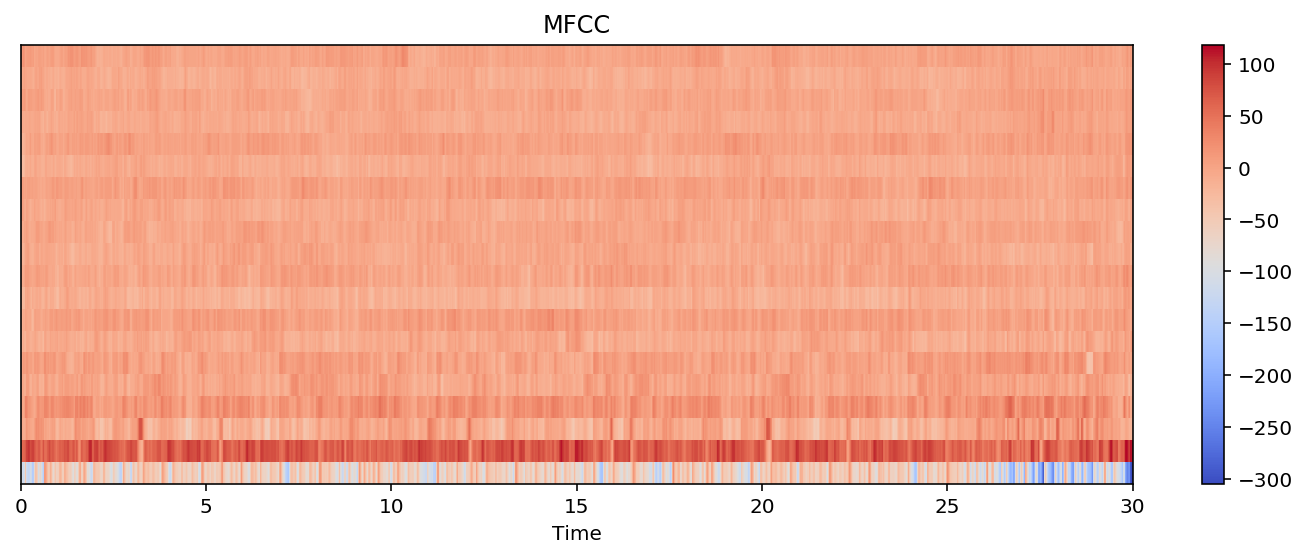

In [8]:
>>> import matplotlib.pyplot as plt
>>> plt.figure(figsize=(10, 4))
>>> librosa.display.specshow(M, x_axis='time')
>>> plt.colorbar()
>>> plt.title('MFCC')
>>> plt.tight_layout()

In [11]:
def get_mfcc(mp3_url):
    """
    Returns MFCC matrix from mp3 url
    """
    y, sr = load_mp3_from_url(mp3_url)
    M = librosa.feature.mfcc(y = y, sr = sr)
    return M

In [16]:
M = get_mfcc(mp3_url)

In [21]:
type(M[0,0])

numpy.float64

Write a script that runs through every song in my database, finds the preview_url, and adds to a new collection an entry with the following features

    Producer
    Track
    Album
    Artist
    Spotify_track_id
    preview_url
    MFCC
    songs_mongo_id

In [36]:
import time

In [37]:
start = time.time()
song_list = []
for i, song in enumerate(collection.find()):
    if song['track_info']['preview_url'] != None:
        producer = song['producer']
        track = song['track']
        album = song['album']
        artist = song['artist']
        spotify_id = song['spotify_id']
        preview_url = song['track_info']['preview_url']
        MFCC = get_mfcc(preview_url)
        songs_mongo_id = song['_id']
        song_list.append( (producer, track, album, artist, spotify_id, preview_url, MFCC, songs_mongo_id) )
    if len(song_list) > 10:
        end = time.time()
        print('Time to process {} songs: {} seconds'.format(len(song_list), end-start))
        break

Time to process 11 songs: 17.893984079360962 seconds


In [19]:
a['track_info']['preview_url']

In [29]:
[a,a] != None

True

In [5]:
print('Pi is about {:.2f}'.format(3.14159))

Pi is about 3.14


In [34]:
# Let's get a list of producers, get 100 songs for each producer and put the MFCCs in a new Mongo Collection

producers = collection.distinct('producer') #list of all producers in db

mfcc_tab = db['mfcc']
mfcc_collection = db.mfcc_tab

for producer in producers:
    start = time.time()
    print()
    print('-'*20)
    print('Producer: {}'.format(producer))
    print('-'*20)
    print()
    song_count = 0
    for i, song in enumerate(collection.find({'producer':producer})):
        if song['track_info']['preview_url'] != None:
            
            # get data from collection
            producer = song['producer']
            track = song['track']
            album = song['album']
            artist = song['artist']
            spotify_id = song['spotify_id']
            preview_url = song['track_info']['preview_url']
            MFCC = get_mfcc(preview_url)
            songs_mongo_id = song['_id']
            
            # add entry to mongodb:
            myquery = { "producer": producer,
                        "spotify_id" : spotify_id }

            newvalues = { "$set": {'producer':producer,
                                   'track':track,
                                   'artist':artist,
                                   'album':album,
                                   'spotify_id':spotify_id,
                                   'preview_url':preview_url,
                                   'MFCC':MFCC.tolist(),
                                   'songs_mongs_id':songs_mongo_id
                                  }
                        }

            mfcc_collection.update_one(myquery, newvalues, upsert = True)
            song_count += 1
            print('{} by {} added.'.format(track,artist))
        
        # check if we have enough songs
        if song_count >= 100:
            end = time.time()
            print('Time to process {} songs by {}: {:.2f} seconds'.format(len(song_list), producer, end-start))
            break


--------------------
Producer: George Martin
--------------------


Act Naturally by Buck Owens and the Buckaroos added.


Alfie by Cilla Black added.


Amber Cascades by America added.


Anyone Who Had a Heart by Dionne Warwick added.


Baby It's You by The Shirelles added.


The Best of Me by Cliff Richard added.


Can't Buy Me Love by the Beatles added.


Chains by The Cookies added.


Everything Works If You Let It - Full Version by Cheap Trick added.


Ferry Cross the Mersey - Stereo; 1997 Remaster by Gerry & The Pacemakers added.


Hello Little Girl by The Fourmost added.


How Do You Do It? by Gerry and the Pacemakers added.


Hymn by Ultravox added.


I Just Don't Understand by Ann-Margret added.


I Like It by Gerry and the Pacemakers added.



KeyboardInterrupt: 

In [35]:
a = mfcc_collection.find_one()

In [36]:
a

{'_id': ObjectId('5ca443f7887867868983752c'),
 'producer': 'George Martin',
 'spotify_id': '2LClPTK0FNl4AnOfKUJBQw',
 'MFCC': [[-36.601721668718625,
   -30.620147853873853,
   -44.414614258016,
   -56.04379954668956,
   -57.749620073702985,
   -29.33999057754873,
   -12.124192246796131,
   -16.01012961190897,
   -25.195318784291775,
   -34.89520463078293,
   -42.41178057620694,
   -45.531810634540754,
   -46.24729623610581,
   -46.426318015125105,
   -55.56747501226501,
   -64.14224758941695,
   -68.34037732903091,
   -67.51517567251359,
   -18.725078298844895,
   21.919335618208702,
   29.566378926767324,
   15.94498116544831,
   -5.483929009591928,
   -17.492582323588042,
   -31.310795806647807,
   -40.52195285504851,
   -46.793758166347814,
   -53.08762431789366,
   -55.37457042645199,
   -60.55382570672483,
   -54.90811620438674,
   -30.46136724859664,
   -14.267163587686362,
   -22.528297847810315,
   -29.97612176731545,
   -34.791983230311324,
   -39.67504986919399,
   -47.948210